# Разработка LGD модели
Loss given default (LGD) объем активов Банка, который будет утерян в случае дефолта клиента, вычисляется как доля от задолженности на момент дефолта. Для задания подготовлен ситнетический набор данных.

В рамках хакатона "ScoringDay 2021 LGD Prediction" сабмиты принимаем до 09:00 19 апреля 2021 года (время московское)

Для оценки качества модели используем метрику MAE
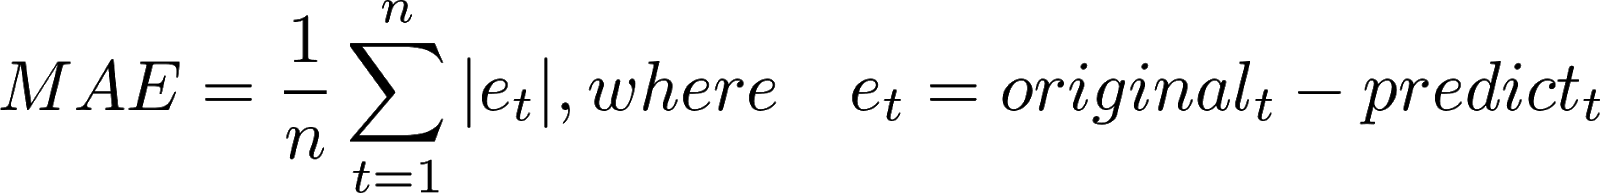


**Содержание проекта**

- [1. Подготовка данных](#1.-Подготовка-данных)
 - [1.1 Импорт библиотек](#1.1-Импорт-библиотек)
 - [1.2 Загрузка данных](#1.2-Загрузка-данных)
 - [1.3 График распределения фактического LGD](#1.3-График-распределения-фактического-LGD)
- [2. Создание признаков](#2.-Создание-признаков)
 - [2.1 Взгляд на данные](#2.1-Взгляд-на-данные)
 - [2.2 Создание категориальных признаков](#2.2-Создание-категориальных-признаков)
 - [2.3 Создание количественных признаков](#2.3-Создание-количественных-признаков)
 - [2.4 Подготовка выборки для обучения](#2.4-Подготовка-выборки-для-обучения)
- [3. Обучение модели и анализ результатов](#3.-Обучение-модели-и-анализ-результатов)
- [4. Submit](#4.-Submit)

# 1. Подготовка данных

## 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from math import log
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor, Pool, cv
%config InlineBackend.figure_format = 'retina'

## 1.2 Загрузка данных

In [2]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv
train_df = pd.read_csv('LGD-data-train.csv', sep=';')
test_df = pd.read_csv('LGD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

--2021-04-19 10:31:15--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-train.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 242368 (237K) [text/plain]
Сохранение в: «LGD-data-train.csv.3»

LGD-data-train.csv. 100%[===================>] 236,69K  --.-KB/s    за 0,09s   

2021-04-19 10:31:15 (2,52 MB/s) - «LGD-data-train.csv.3» сохранён [242368/242368]

--2021-04-19 10:31:15--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-test.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожи

Описание данных

In [3]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Мы видим, что можно выделить условно два типа признаков - данные финансовой отчетности и прочие характеристики юр.лиц.

In [4]:
train_df.shape

(1400, 38)

In [5]:
test_df.shape

(691, 37)

Выборка содержит информацию по 2091 клиентам Банка. 1400 наблюдение в выборке для разработки 691 в тестовой выборке.

In [6]:
train_df['lgd'].values.mean()

0.6333485905181601

Среднее значение LGD в выборке 63,33%

In [7]:
train_df

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range,collateral,lgd
0,188,44755000.0,42665000.0,42665000.0,0.0,0.0,2090000.0,-405000.0,1685000.0,2000.0,...,1,1,10000.0,1,0,0,0,[1-100],Изгородь металлическая,0.385417
1,213,23179000.0,22064000.0,22064000.0,0.0,0.0,1115000.0,115000.0,1230000.0,265000.0,...,23,23,10000.0,1,0,0,0,[1-100],нежилое помещение П4,0.371287
2,743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,10000.0,1,0,0,0,[1-100],гараж,1.000000
3,952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,20000.0,2,0,0,0,[1-100],Легковой автомобиль,1.000000
4,1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,16,10000.0,1,0,0,0,[1-100],гараж,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,273978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23,23,142500.0,1,0,0,0,[1-100],квартира,0.000000
1396,274002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,15625.0,2,0,0,0,[1-100],Поручительство,1.000000
1397,274314,229505000.0,221812000.0,221812000.0,0.0,0.0,7693000.0,-4455000.0,3238000.0,648000.0,...,27,27,12000.0,2,0,0,0,[1-100],Хозяйственно-бытовое здание (смпримеч),0.000000
1398,274494,62309000.0,55829000.0,55829000.0,0.0,0.0,6480000.0,-1257000.0,5223000.0,0.0,...,23,23,85000.0,1,0,0,0,[1-100],Легковой автомобиль,0.000000


## 1.3 График распределения фактического LGD

No handles with labels found to put in legend.


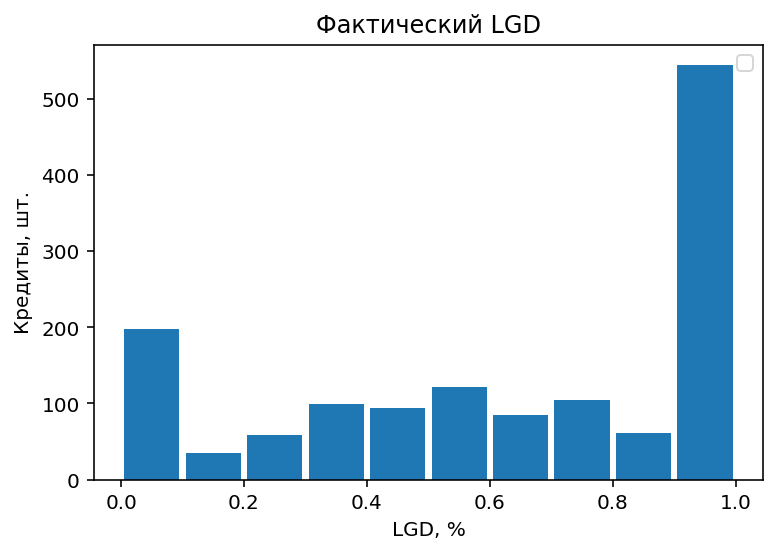

In [8]:
import matplotlib.pyplot as plt
plt.hist(train_df['lgd'].values, histtype='bar', rwidth=0.9)
plt.xlabel('LGD, %')
plt.ylabel('Кредиты, шт.')
plt.title('Фактический LGD')
plt.legend()
plt.show()

Видим, что распределение LGD имеет U-образную форму - больше всего значений около нуля и около единицы - то есть, банк либо все вернет, либо все потеряет.

# 2. Создание признаков

## 2.1 Взгляд на данные

Прежде, чем генерировать новые данные, посмотрим, нет ли в них пропусков.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     1400 non-null   int64  
 1   ar_revenue                    530 non-null    float64
 2   ar_total_expenses             530 non-null    float64
 3   ar_sale_cost                  530 non-null    float64
 4   ar_selling_expenses           530 non-null    float64
 5   ar_management_expenses        530 non-null    float64
 6   ar_sale_profit                530 non-null    float64
 7   ar_balance_of_rvns_and_expns  530 non-null    float64
 8   ar_profit_before_tax          530 non-null    float64
 9   ar_taxes                      530 non-null    float64
 10  ar_other_profit_and_losses    530 non-null    float64
 11  ar_net_profit                 530 non-null    float64
 12  ab_immobilized_assets         530 non-null    float64
 13  ab_

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     691 non-null    int64  
 1   ar_revenue                    266 non-null    float64
 2   ar_total_expenses             266 non-null    float64
 3   ar_sale_cost                  266 non-null    float64
 4   ar_selling_expenses           266 non-null    float64
 5   ar_management_expenses        266 non-null    float64
 6   ar_sale_profit                266 non-null    float64
 7   ar_balance_of_rvns_and_expns  266 non-null    float64
 8   ar_profit_before_tax          266 non-null    float64
 9   ar_taxes                      266 non-null    float64
 10  ar_other_profit_and_losses    266 non-null    float64
 11  ar_net_profit                 266 non-null    float64
 12  ab_immobilized_assets         266 non-null    float64
 13  ab_mo

Пропуски есть, видно, что данные финансовой отчетности отсутствуют почти у 900 объектов.

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     691 non-null    int64  
 1   ar_revenue                    266 non-null    float64
 2   ar_total_expenses             266 non-null    float64
 3   ar_sale_cost                  266 non-null    float64
 4   ar_selling_expenses           266 non-null    float64
 5   ar_management_expenses        266 non-null    float64
 6   ar_sale_profit                266 non-null    float64
 7   ar_balance_of_rvns_and_expns  266 non-null    float64
 8   ar_profit_before_tax          266 non-null    float64
 9   ar_taxes                      266 non-null    float64
 10  ar_other_profit_and_losses    266 non-null    float64
 11  ar_net_profit                 266 non-null    float64
 12  ab_immobilized_assets         266 non-null    float64
 13  ab_mo

В тестовой выборке данные фин.отчетности отсутсвтуют более чем у 400 объектов из 691.

Посмотрим, нет ли дубликатов.

In [12]:
train_df[train_df.duplicated()]

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range,collateral,lgd


In [13]:
test_df[test_df.duplicated()]

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range,collateral


'record_id' можно использовать в качестве индекса.

In [14]:
X_train = train_df.copy().set_index('record_id')

Проверим, не дублируют ли друг друга столбцы 'head_actual_age', 'cap_actual_age', 'adr_actual_age'.

In [15]:
print((X_train['head_actual_age'] == X_train['cap_actual_age']).sum())
print((X_train['head_actual_age'] == X_train['adr_actual_age']).sum())
print((test_df['head_actual_age'] == test_df['cap_actual_age']).sum())
print((test_df['head_actual_age'] == test_df['adr_actual_age']).sum())

1400
1400
691
691


Столбцы друг друга дублируют, значит, два из них можно удалить.

Исследуем признаки, характризующие отношение компании к системообразующему или стратегическому предприятию.

In [16]:
display(X_train['ul_systematizing_flg'].value_counts())
display(X_train['ul_strategic_flg'].value_counts())
display(test_df['ul_strategic_flg'].value_counts())
display(test_df['ul_systematizing_flg'].value_counts())

0    1400
Name: ul_systematizing_flg, dtype: int64

0    1400
Name: ul_strategic_flg, dtype: int64

0    691
Name: ul_strategic_flg, dtype: int64

0    691
Name: ul_systematizing_flg, dtype: int64

Видно, что в обучающей и тестовой выборке все значения равны нулю, значит, эти признаки следует удалить.

Разобьем наши признаки в три группы - данные отчета о прибылях и убытках, данные бухгалтерского баланса и прочие характеристики.

In [17]:
list_of_cols = X_train.drop(['ul_systematizing_flg','ul_strategic_flg','cap_actual_age',
                             'adr_actual_age'], axis=1).columns
is_cols = [col for col in list_of_cols if 'ar_' in col] 
bs_cols = [col for col in list_of_cols if 'ab_' in col]
other_cols = list(set(list_of_cols) - set(is_cols) - set(bs_cols) - {'lgd'})
other_cols

['collateral',
 'ul_branch_cnt',
 'ul_staff_range',
 'bus_age',
 'head_actual_age',
 'ogrn_age',
 'ul_capital_sum',
 'ul_founders_cnt']

## 2.2 Создание категориальных признаков

Снизим разрядность финансовых данных - разелим на 1000, предполагая, что теперь данные в тысячах рублей.

In [18]:
X_train[is_cols + bs_cols] = X_train[is_cols + bs_cols] / 1000
X_train['ul_capital_sum'] = X_train['ul_capital_sum'] / 1000

test_df[is_cols + bs_cols] = test_df[is_cols + bs_cols] / 1000
test_df['ul_capital_sum'] = test_df['ul_capital_sum'] / 1000

X_train

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range,collateral,lgd
record_id,,,,,,,,,,,,,,,,,,,,,
188,44755.0,42665.0,42665.0,0.0,0.0,2090.0,-405.0,1685.0,2.0,0.0,...,1,1,10.000,1,0,0,0,[1-100],Изгородь металлическая,0.385417
213,23179.0,22064.0,22064.0,0.0,0.0,1115.0,115.0,1230.0,265.0,0.0,...,23,23,10.000,1,0,0,0,[1-100],нежилое помещение П4,0.371287
743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,10.000,1,0,0,0,[1-100],гараж,1.000000
952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,20.000,2,0,0,0,[1-100],Легковой автомобиль,1.000000
1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,16,10.000,1,0,0,0,[1-100],гараж,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23,23,142.500,1,0,0,0,[1-100],квартира,0.000000
274002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,15.625,2,0,0,0,[1-100],Поручительство,1.000000
274314,229505.0,221812.0,221812.0,0.0,0.0,7693.0,-4455.0,3238.0,648.0,0.0,...,27,27,12.000,2,0,0,0,[1-100],Хозяйственно-бытовое здание (смпримеч),0.000000


Добавим категориальный признак - наличие фин. отчетности.

In [19]:
def fin_stat(revenue):
    """Функция принимает на вход ячейку со значением выручки.
    Пропуск или ноль означает отсутсвие фин. отчетности."""
    if math.isnan(revenue) == True or revenue == 0:
        return 'without_fin_statement'
    else:
        return 'with_fin_statement'

In [20]:
X_train['fin_statement'] = X_train['ar_revenue'].apply(fin_stat)
X_train['fin_statement'].value_counts()

without_fin_statement    897
with_fin_statement       503
Name: fin_statement, dtype: int64

In [21]:
test_df['fin_statement'] = test_df['ar_revenue'].apply(fin_stat)
test_df['fin_statement'].value_counts()

without_fin_statement    443
with_fin_statement       248
Name: fin_statement, dtype: int64

In [22]:
gen_cols = []
gen_cols.append('fin_statement')

Создадим функцию для создания сводных таблиц, где рассчитывются значения LGD в зависимости от других признаков.

In [23]:
def piv_tab(df, index):
    
    """Функция принимает датафрейм и колонку, которую будем использовать в качестве индекса.
    В качестве значений установлено LGD, аггрегуирующие функции - медиана, средняя, подсчет"""
    
    return df.pivot_table(index=index, values='lgd', aggfunc=['median', 'mean', 'count'])

In [24]:
piv_tab(X_train, 'fin_statement')

,median,mean,count
,lgd,lgd,lgd
fin_statement,,,
with_fin_statement,0.404329,0.413974,503
without_fin_statement,0.961111,0.756365,897


Из таблицы выше видно, что у объектов с финансовой отчетностью средний LGD - 0.41, а у объектов без отчетности - 0.75.

Также мы видели, что у каждого объекта есть залог, но он описан разными способами. Предлагается проанализировать залоги, выделить несколько категорий и провести категоризацию.

In [25]:
def col_cat(col):
    #Функция принимает на вход ячейку с описанием залога,
    #в зависимости от входящей в описание подстроки функция возвращает одну из трех категорий
    col = col.lower()
    
    if 'автом' in col and len(col)<=30:
        return 'автомобиль или поручительство'
    elif 'квартира' in col:
        return 'жилое здание'
    elif 'дом однок' in col:
        return 'жилое здание'
    elif 'нежилое' in col: 
        return 'нежилое здание'
    elif 'жилое' in col:
        return 'жилое здание'
    elif 'поручительство' in col:
        return 'автомобиль или поручительство'
    elif 'автотранспортное средство' in col:
        return 'автомобиль или поручительство'
    elif 'автобус' in col:
        return 'автомобиль или поручительство'
    else:
        return 'нежилое здание'       

In [26]:
X_train['col_cat'] = X_train['collateral'].apply(col_cat)
test_df['col_cat'] = test_df['collateral'].apply(col_cat)

In [27]:
gen_cols.append('col_cat')

In [28]:
test_df['col_cat'].value_counts()

нежилое здание                   280
автомобиль или поручительство    270
жилое здание                     141
Name: col_cat, dtype: int64

In [29]:
piv_tab(X_train, 'col_cat')

,median,mean,count
,lgd,lgd,lgd
col_cat,,,
автомобиль или поручительство,0.850000,0.707823,522
жилое здание,0.527141,0.481408,308
нежилое здание,0.692014,0.647246,570


Мы выделили три категории залога - "автомобиль или поручительство", "жилое здание" (куда относятся жилые дома и квартиры) и "нежилое здание" - здесь представлены различные нежилые здания, а также прочие помещения и сооружения.

Автомобили и поручительства были объединены в одну категорию, так как среднее и медианное значение LGD у них было очень похоже.

Изучим корреляцию у признаков, присутствующих у всех объектов.

In [30]:
X_train[['lgd', 'bus_age', 'ogrn_age', 'ul_capital_sum','ul_founders_cnt', 'head_actual_age']].corr()

,lgd,bus_age,ogrn_age,ul_capital_sum,ul_founders_cnt,head_actual_age
lgd,1.000000,-0.633830,-0.606476,-0.122667,-0.107864,-0.151420
bus_age,-0.633830,1.000000,0.865256,0.150170,0.147475,0.145634
ogrn_age,-0.606476,0.865256,1.000000,0.115080,0.071795,0.197052
ul_capital_sum,-0.122667,0.150170,0.115080,1.000000,0.076775,-0.006047
ul_founders_cnt,-0.107864,0.147475,0.071795,0.076775,1.000000,0.068261
head_actual_age,-0.151420,0.145634,0.197052,-0.006047,0.068261,1.000000


Здесь мы сразу обнаруживаем важное наблюдение - признак "срок ведения бизнеса" хорошо коррелирует с целевым признаком. Также чуть менее сильная связь с таргетом у признака "срок с момента присваивания ОГРН". На самом деле, нам стоит задуматься о том, нужны ли два похожих признака, характеризующих заемщика с одной стороны - насколько давно ведется его бизнес.

Далее рассмотрим только ту часть выборки, где есть данные финансовой отчетности.

In [31]:
no_brackets_train = X_train.dropna(axis=0)
no_brackets_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 188 to 274611
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_revenue                    530 non-null    float64
 1   ar_total_expenses             530 non-null    float64
 2   ar_sale_cost                  530 non-null    float64
 3   ar_selling_expenses           530 non-null    float64
 4   ar_management_expenses        530 non-null    float64
 5   ar_sale_profit                530 non-null    float64
 6   ar_balance_of_rvns_and_expns  530 non-null    float64
 7   ar_profit_before_tax          530 non-null    float64
 8   ar_taxes                      530 non-null    float64
 9   ar_other_profit_and_losses    530 non-null    float64
 10  ar_net_profit                 530 non-null    float64
 11  ab_immobilized_assets         530 non-null    float64
 12  ab_mobile_current_assets      530 non-null    float64
 13  

In [32]:
no_brackets_train[is_cols]

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit
record_id,,,,,,,,,,,
188,44755.0,42665.0,42665.0,0.0,0.0,2090.0,-405.0,1685.0,2.0,0.0,1683.0
213,23179.0,22064.0,22064.0,0.0,0.0,1115.0,115.0,1230.0,265.0,0.0,965.0
1047,21919.0,21317.0,16106.0,5211.0,0.0,602.0,-158.0,444.0,129.0,0.0,315.0
1060,0.0,78.0,78.0,0.0,0.0,-78.0,0.0,-78.0,0.0,0.0,-78.0
1970,191623.0,189446.0,189446.0,0.0,0.0,2177.0,-3136.0,-959.0,86.0,0.0,-1045.0
...,...,...,...,...,...,...,...,...,...,...,...
273973,35545.0,32863.0,32863.0,0.0,0.0,2682.0,-262.0,2420.0,27.0,0.0,2393.0
273977,2591.0,1964.0,1964.0,0.0,0.0,627.0,0.0,627.0,38.0,0.0,589.0
274314,229505.0,221812.0,221812.0,0.0,0.0,7693.0,-4455.0,3238.0,648.0,0.0,2590.0


Построим график взаимосязи выручки, срока ведения бизнеса и LGD.

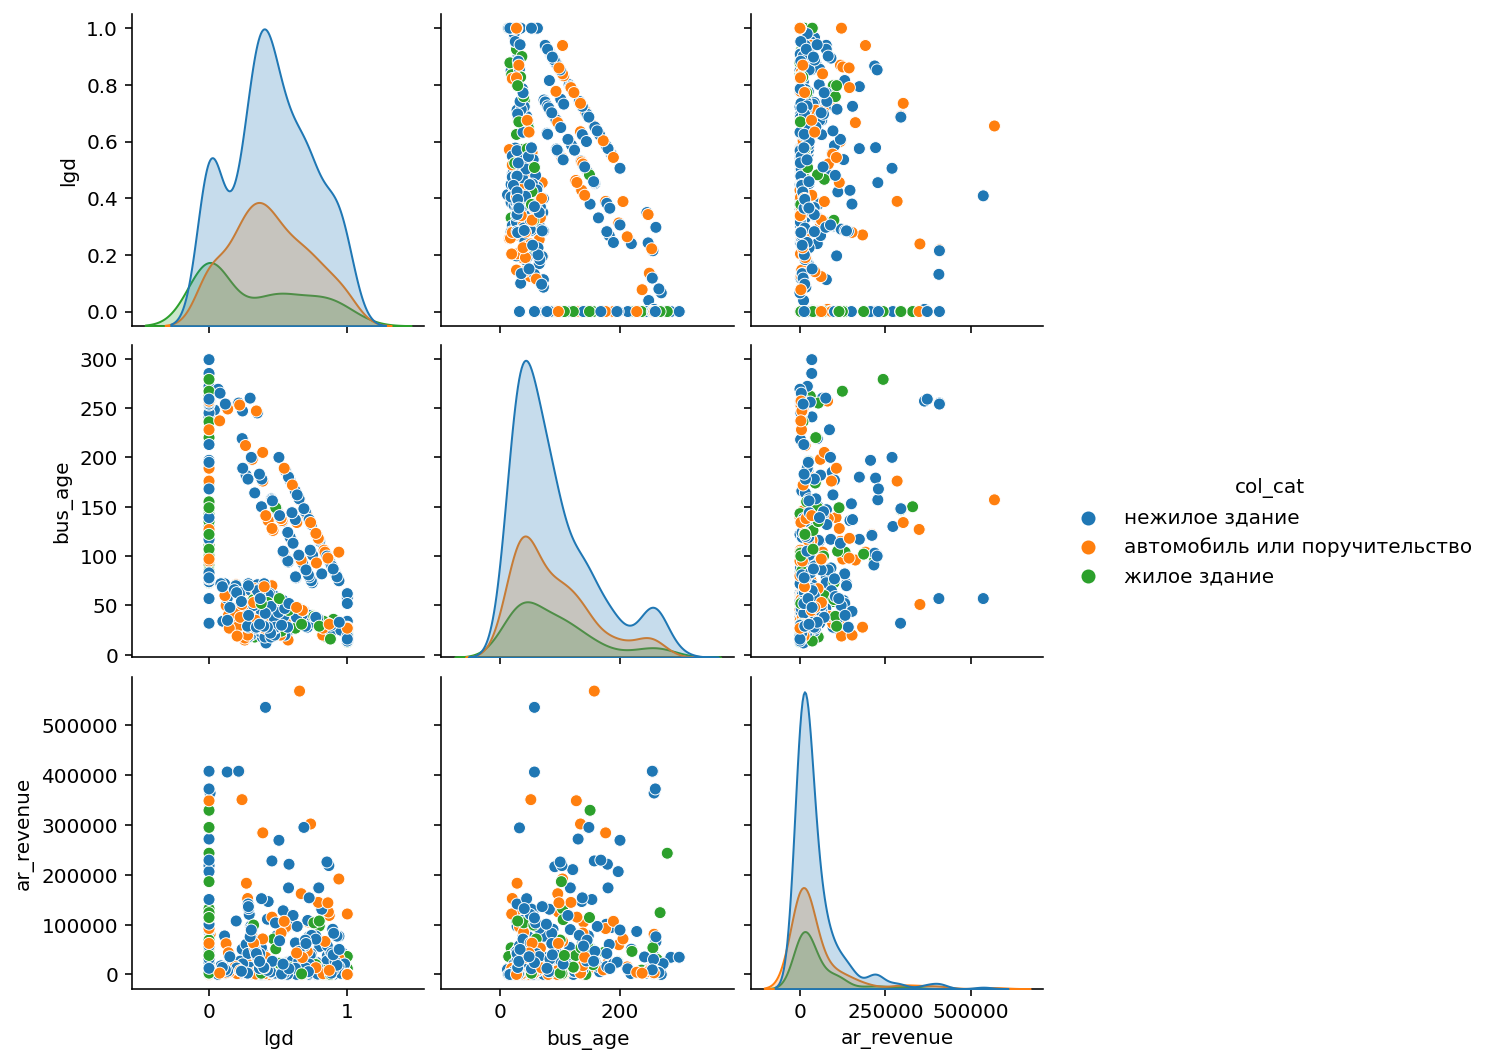

In [33]:
sns.pairplot(no_brackets_train[['lgd', 'bus_age', 'ar_revenue', 'col_cat']], hue='col_cat');

Мы видим, что величина выручки распределена таким образом, что существенная часть компаний по выручке не превышает 50 млн рублей.

В связи с этим можно попробовать выделить категории компаний по выручке.

In [34]:
def rev_cat(revenue):
    """Функция принимает значение выручки, если там пропуск или меньше 50 млн рублей, то мы говорим,
    что это маленькая компания. В противном случае - корпорация. Порог в 50 млн рублей установлен, чтобы соблюсти баланс
    между достаточным количеством объектов в выделяемой категории и разницей в распределении LGD по категориям
   """
    if math.isnan(revenue) == True or revenue < 50000:
        return 'unknown'
    else:
        return 'corporation'

In [35]:
X_train['rev_cat'] = X_train['ar_revenue'].apply(rev_cat)
test_df['rev_cat'] = test_df['ar_revenue'].apply(rev_cat)

In [36]:
gen_cols.append('rev_cat')

In [37]:
piv_tab(X_train, 'rev_cat')

,median,mean,count
,lgd,lgd,lgd
rev_cat,,,
corporation,0.330479,0.393104,143
unknown,0.741667,0.660680,1257


In [38]:
no_brackets_train = X_train.dropna(axis=0)

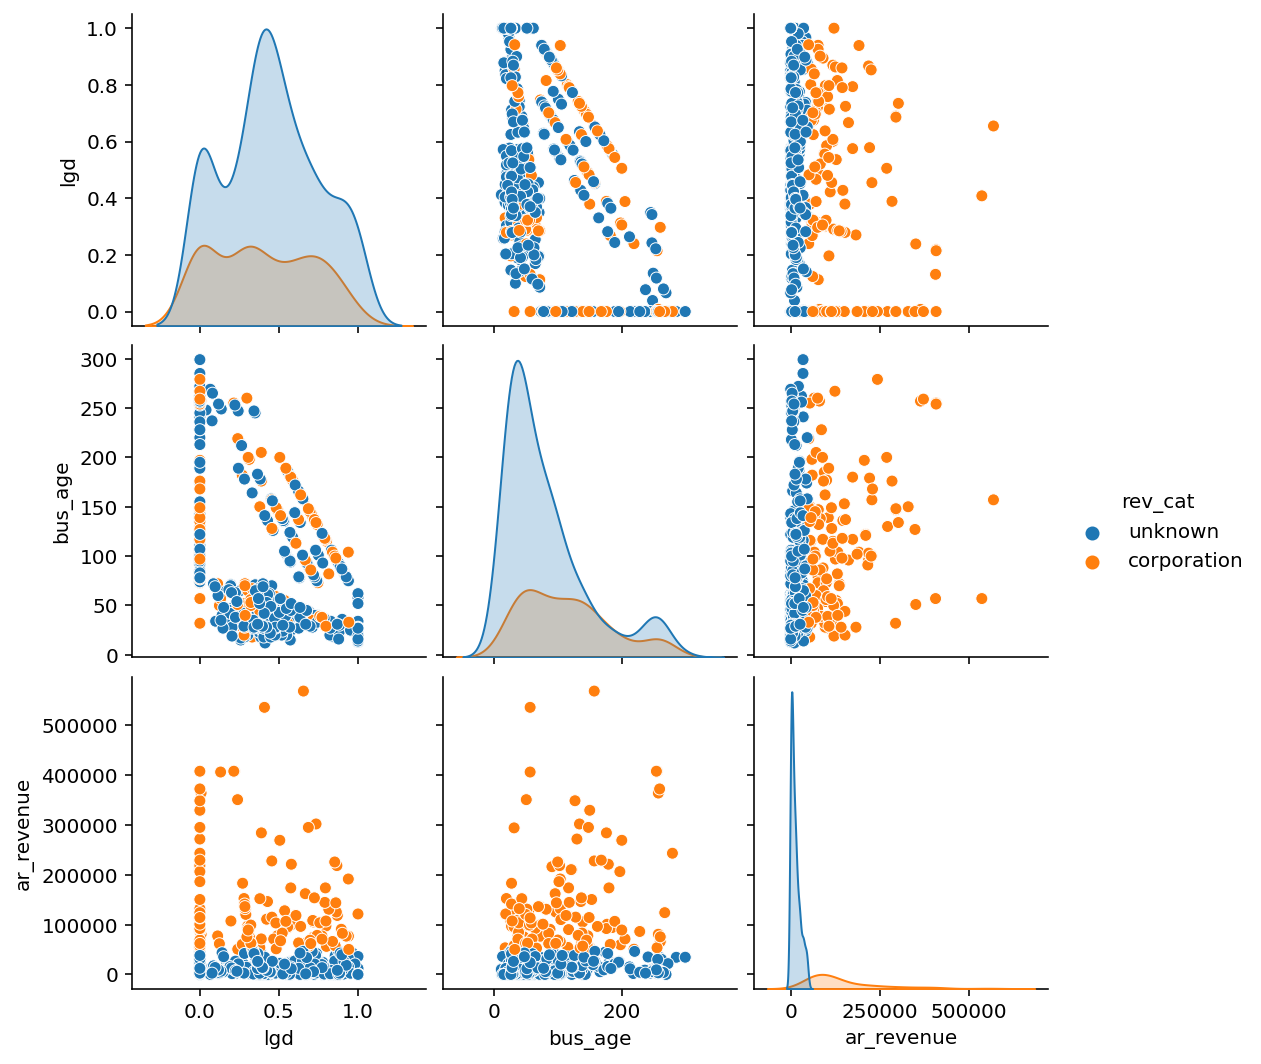

In [39]:
sns.pairplot(no_brackets_train[['lgd', 'bus_age', 'ar_revenue', 'rev_cat']], hue='rev_cat');

Видно, что распределение LGD у корпораций имеет достаточно равномерный вид. В то время, как у более мелких компаний - похоже на колоколообразное распределение.

Далее посмотрим на такой признак, как величина уставного капитала - 'ul_capital_sum'

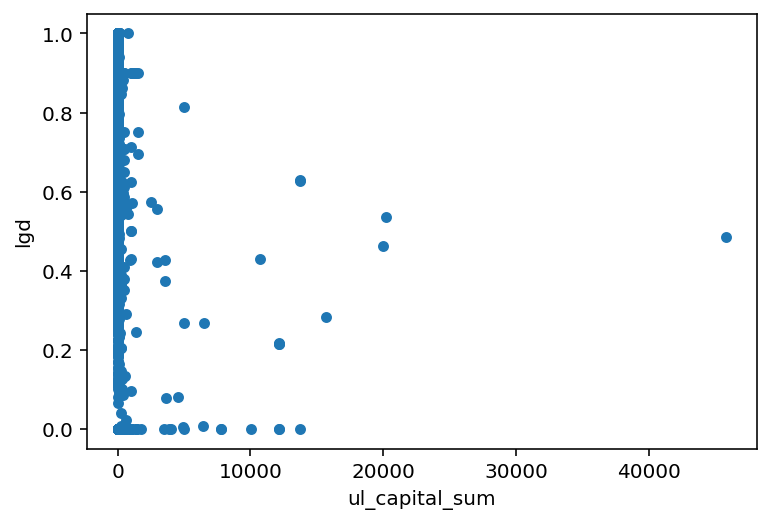

In [40]:
X_train.plot(kind='scatter', x='ul_capital_sum', y='lgd');

В целом видно, что у подавляющего большинства компаний величина уставного капитала лежит в районе 10 000 рублей. И есть ряд компаний, у которых этот показатель выше. Возможно, для нас будет полезно отдельно категоризировать те компании, с уставным капиталом выше какой-то границы.

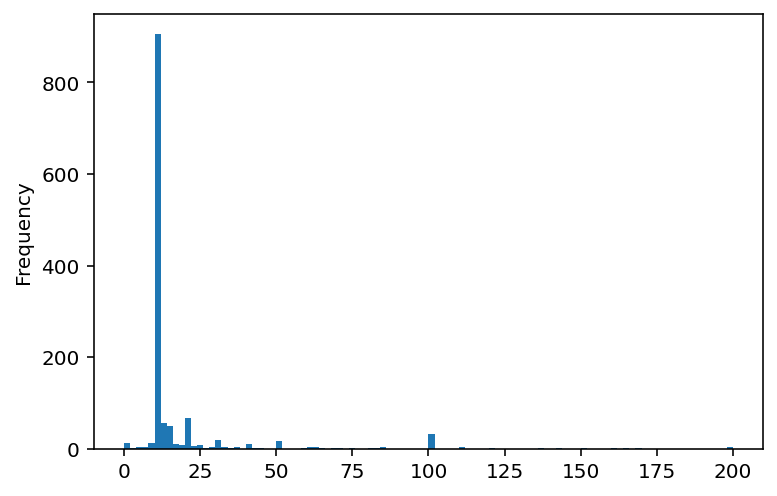

In [41]:
X_train['ul_capital_sum'].plot(kind='hist', range=(0,200), bins=100);

Видно, что после 100 тыс. рублей есть некий всплеск - эту границу и выберем.

In [42]:
def capital_category(col):
    """Функция принимает величину уставного капитала, если она больше 100 тыс. рублей, то возвращает 'big' - большая компания"""
    if col <= 100:
        return 'small'
    else:
        return 'big'

In [43]:
X_train['capital_cat'] = X_train['ul_capital_sum'].apply(capital_category)
test_df['capital_cat'] = test_df['ul_capital_sum'].apply(capital_category)

In [44]:
gen_cols.append('capital_cat')

In [45]:
piv_tab(X_train, 'capital_cat')

,median,mean,count
,lgd,lgd,lgd
capital_cat,,,
big,0.380554,0.375797,152
small,0.742361,0.664717,1248


In [46]:
test_df.pivot_table(index='capital_cat', values='ar_revenue', aggfunc='count')

,ar_revenue
capital_cat,
big,40
small,226


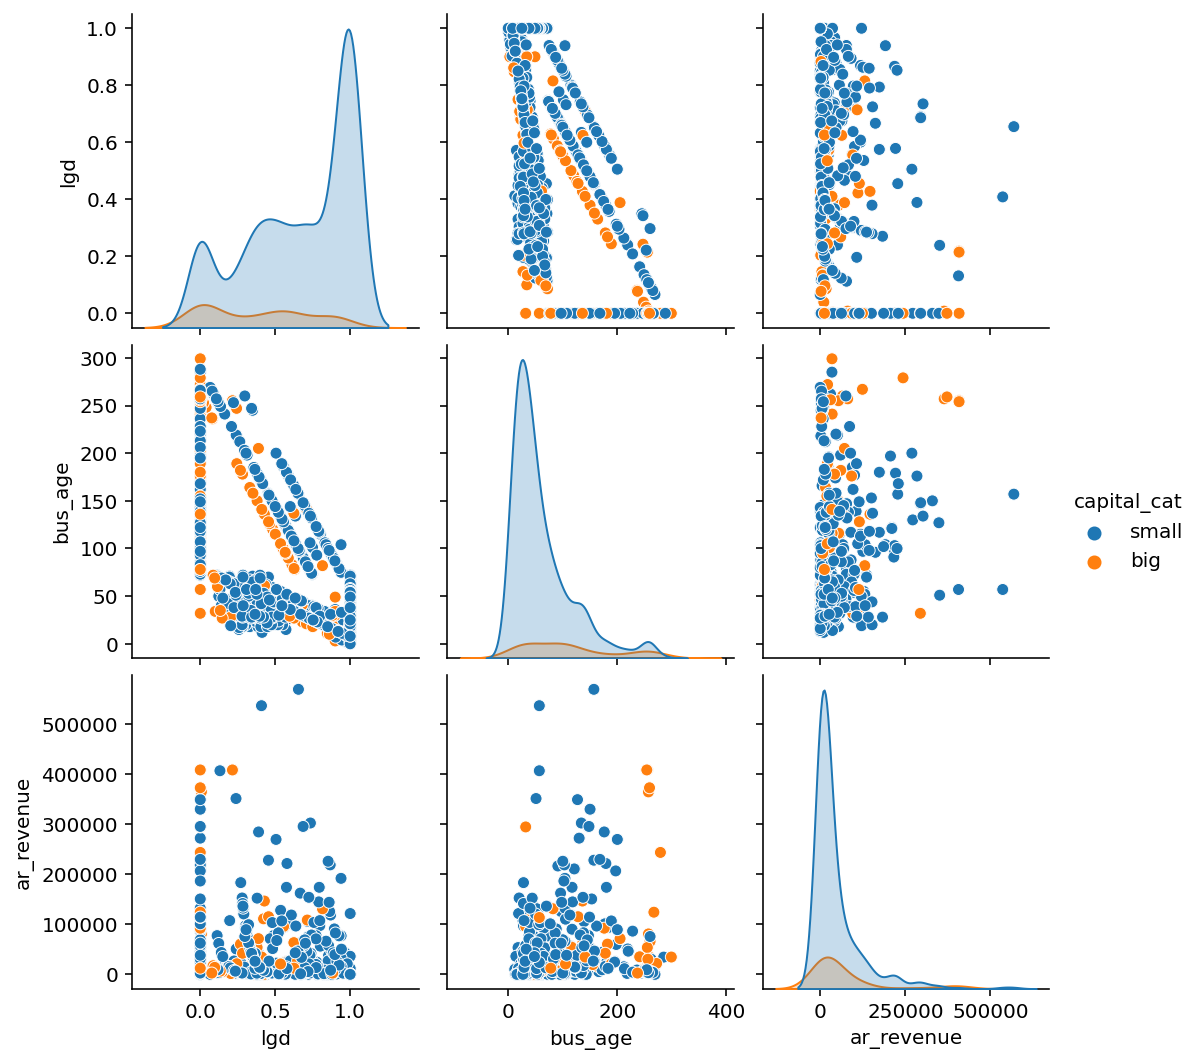

In [47]:
sns.pairplot(X_train[['lgd', 'bus_age', 'ar_revenue', 'capital_cat']], hue='capital_cat');

В обучающей выборке удалось отделить около 150 таких компаний с большим уставным капиталом. Видно, что их распределение lgd отличается от остальных - пик около нуля.

Построим pairplot для этих признаков, присутствующих у всех объектов.

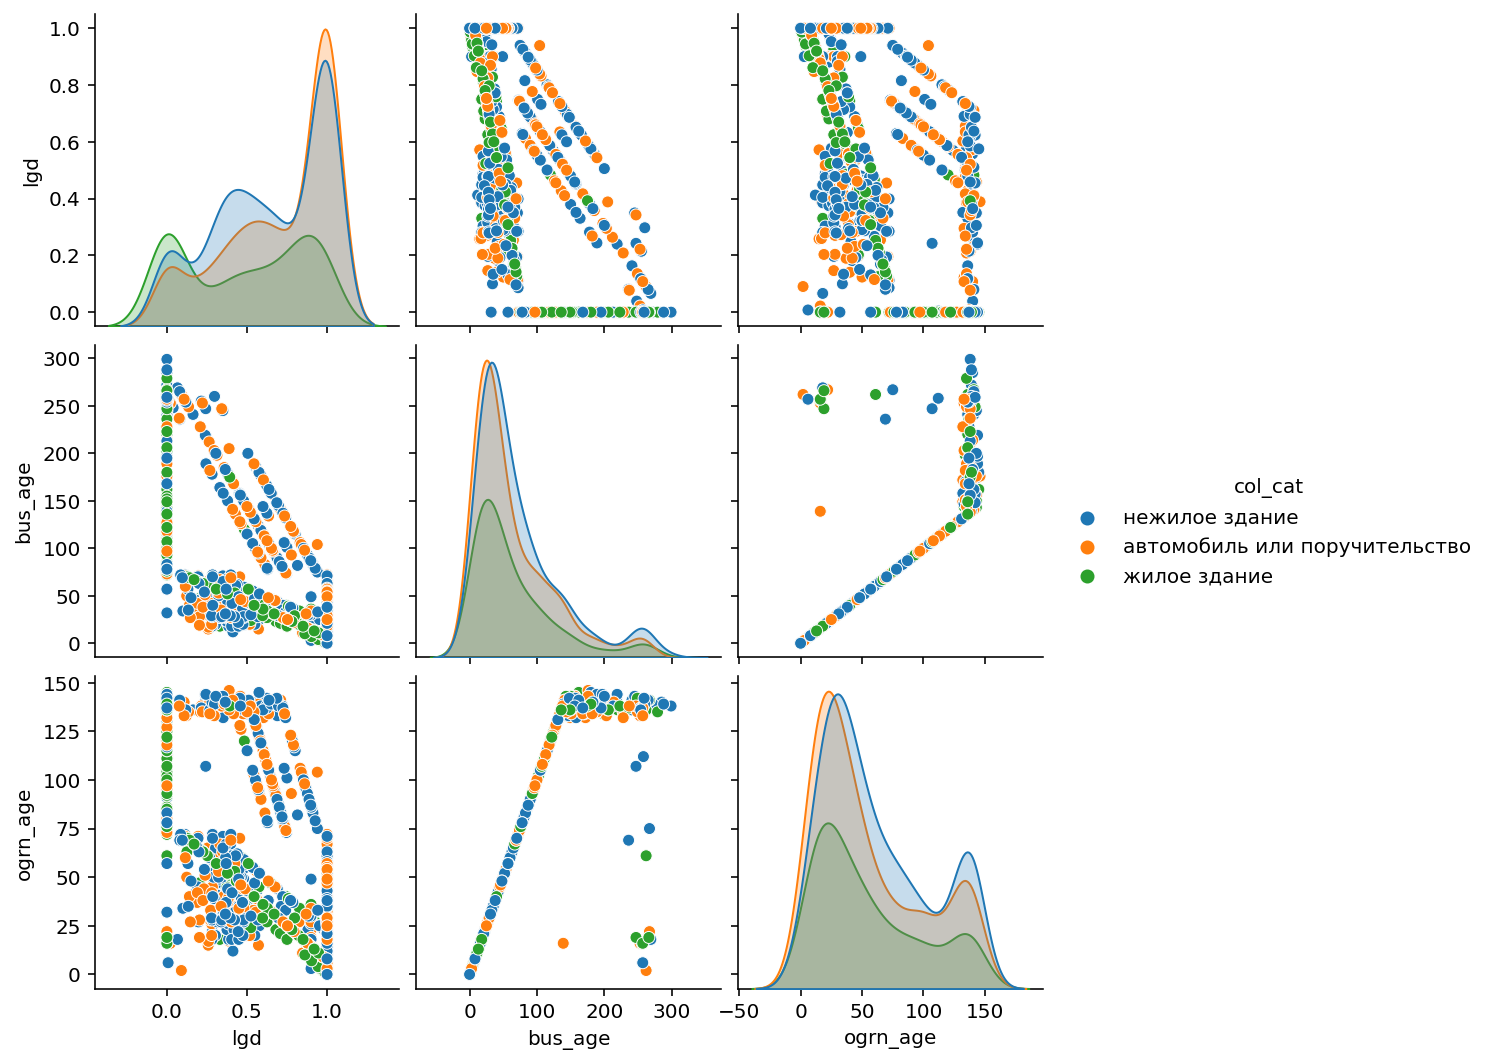

In [48]:
sns.pairplot(X_train[['lgd', 'bus_age', 'ogrn_age', 'col_cat']], hue='col_cat');

Полученные данные интересны - видно, что на графике "срок ведения бизнеса - LGD" можно выделить условно три кластера:
 - объекты, у которых LGD = 0 при любом сроке;
 - объекты, у которых прослеживается обратная линейная зависимость между сроком и LGD;
 - объекты, у которых LGD может принимать любые значения от 0.15 до 1 на сроке до 100 дней

Также можно отметить тот факт, что у заемщиков, у которых в залоге было "жилое здание" по достижении срока ведения бизнеса около 80 - их LGD снижался до нуля, то есть они переходили в категорию безопасных для банка. Это можно отразить отдельным признаком.

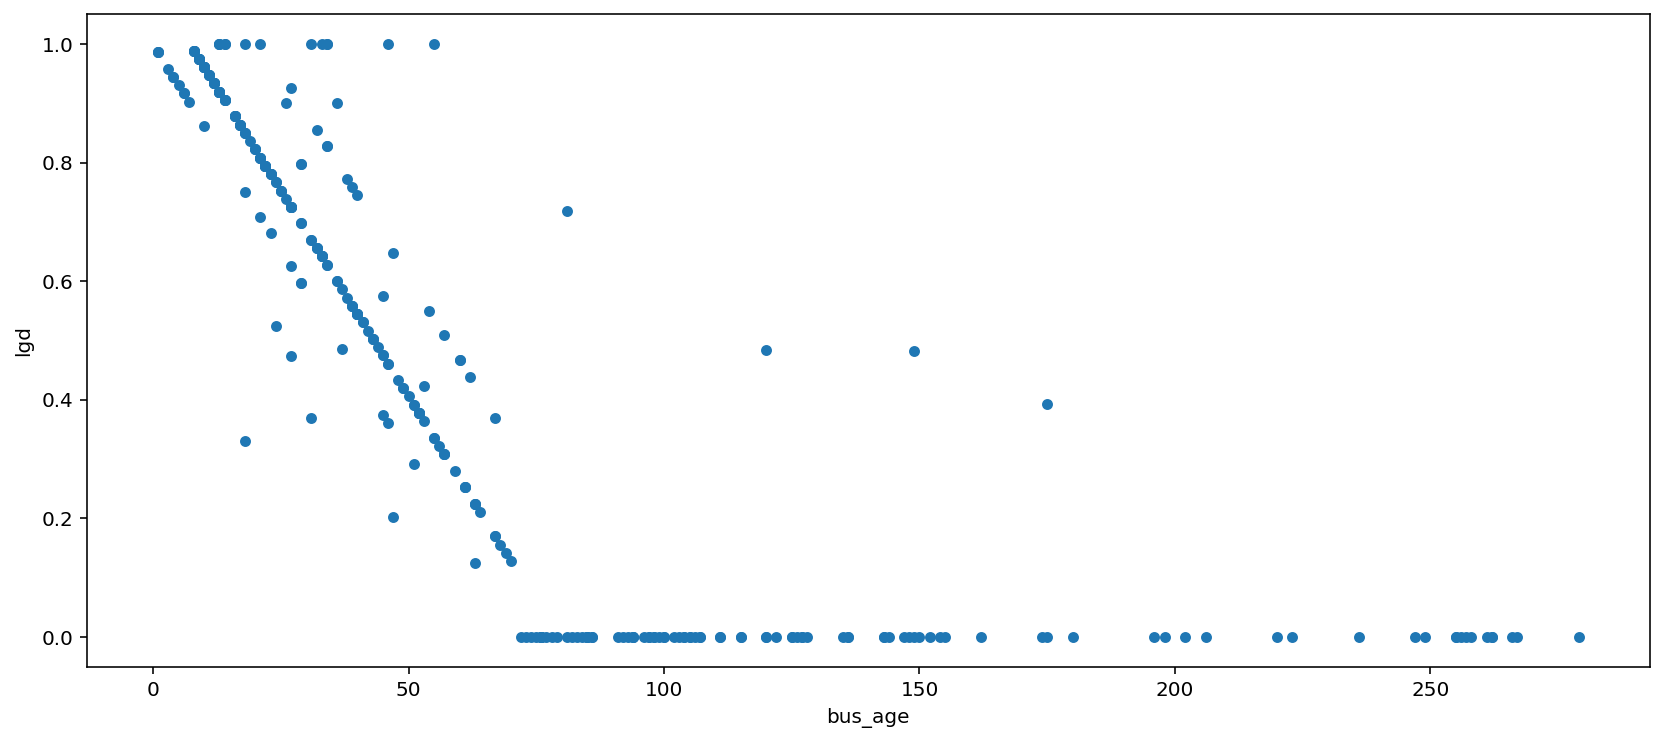

In [49]:
X_train[X_train['col_cat']=='жилое здание'].plot(kind='scatter', x='bus_age', y='lgd', figsize=(14,6));

In [50]:
def safe_debtor(row):
    """Функция принимает на вход ряд, и, если срок бизнеса больше 69, и в залоге жилое здание, то возвращается значение 'zero lgd'"""
    colat = row['col_cat']
    age = row['bus_age']
    
    if colat == 'жилое здание' and age > 69:
        return 'zero lgd'
    else:
        return 'non zero lgd'

In [51]:
X_train['safe_debtor'] = X_train.apply(safe_debtor, axis=1)
test_df['safe_debtor'] = test_df.apply(safe_debtor, axis=1)

In [52]:
gen_cols.append('safe_debtor')

In [53]:
piv_tab(X_train, 'safe_debtor')

,median,mean,count
,lgd,lgd,lgd
safe_debtor,,,
non zero lgd,0.743056,0.680372,1300
zero lgd,0.000000,0.022049,100


In [54]:
X_train[X_train['safe_debtor']=='zero lgd']['lgd'].value_counts()

0.000000    95
0.483333     1
0.392361     1
0.482639     1
0.718750     1
0.127778     1
Name: lgd, dtype: int64

Всего таких надежных заемщиков 100, и только для пяти из них это условие не выполняется.

## 2.3 Создание количественных признаков

Далее проанализируем корреляции признаков-данных финансовой отчетности.

In [55]:
no_brackets_train[is_cols].join(no_brackets_train['lgd']).corr()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,lgd
ar_revenue,1.000000,0.998899,0.990929,0.472857,0.351887,0.340236,-0.255603,0.185858,-0.010481,0.226602,0.207743,-0.146631
ar_total_expenses,0.998899,1.000000,0.989834,0.488453,0.349093,0.295756,-0.240728,0.149317,-0.028614,0.217063,0.172371,-0.144664
ar_sale_cost,0.990929,0.989834,1.000000,0.371578,0.309226,0.337247,-0.220474,0.205939,0.006449,0.205726,0.224807,-0.154932
ar_selling_expenses,0.472857,0.488453,0.371578,1.000000,0.031295,-0.162220,-0.232630,-0.322692,-0.276049,0.132967,-0.280394,-0.021668
ar_management_expenses,0.351887,0.349093,0.309226,0.031295,1.000000,0.167984,-0.076486,0.124589,0.094199,0.148485,0.117788,0.008681
ar_sale_profit,0.340236,0.295756,0.337247,-0.162220,0.167984,1.000000,-0.379539,0.791708,0.360182,0.263347,0.775231,-0.086087
ar_balance_of_rvns_and_expns,-0.255603,-0.240728,-0.220474,-0.232630,-0.076486,-0.379539,1.000000,0.264707,0.066809,-0.183408,0.261108,0.022805
ar_profit_before_tax,0.185858,0.149317,0.205939,-0.322692,0.124589,0.791708,0.264707,1.000000,0.419539,0.153386,0.980451,-0.074672
ar_taxes,-0.010481,-0.028614,0.006449,-0.276049,0.094199,0.360182,0.066809,0.419539,1.000000,0.003890,0.235435,0.041327
ar_other_profit_and_losses,0.226602,0.217063,0.205726,0.132967,0.148485,0.263347,-0.183408,0.153386,0.003890,1.000000,0.196953,0.010323


Видно, что самую тесную связь с LGD имеет признак себестоимости, а выручка, себестоимость и прочие расходы очень сильно коррелируют между собой. Значит, нужно выбирать из-них какой-то один.

Далее посмотрим на балансовые показатели.

In [56]:
no_brackets_train[bs_cols].join(no_brackets_train['lgd']).corr()

,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,lgd
ab_immobilized_assets,1.000000,0.518023,0.493081,0.426135,0.151808,0.090361,0.370949,0.927564,0.575073,0.719112,0.382388,0.268639,0.128385,-0.141423
ab_mobile_current_assets,0.518023,1.000000,0.893790,0.886990,0.315995,0.297814,0.340993,0.549342,0.945506,0.553455,0.601102,0.820798,0.139254,-0.129989
ab_inventory,0.493081,0.893790,1.000000,0.600465,0.058502,0.331611,0.272373,0.507123,0.858239,0.536426,0.590767,0.694611,0.222500,-0.143935
ab_accounts_receivable,0.426135,0.886990,0.600465,1.000000,0.356137,0.202269,0.374857,0.479615,0.817291,0.475392,0.435709,0.760766,0.017635,-0.089141
ab_other_current_assets,0.151808,0.315995,0.058502,0.356137,1.000000,0.018119,-0.051157,0.119039,0.325478,0.013513,0.348339,0.324320,-0.007962,-0.008406
ab_cash_and_securities,0.090361,0.297814,0.331611,0.202269,0.018119,1.000000,0.000651,0.066408,0.366063,0.175311,0.081900,0.401852,0.125844,0.036057
ab_losses,0.370949,0.340993,0.272373,0.374857,-0.051157,0.000651,1.000000,0.560027,0.186751,0.411126,0.053882,0.005859,0.158859,-0.082361
ab_own_capital,0.927564,0.549342,0.507123,0.479615,0.119039,0.066408,0.560027,1.000000,0.496128,0.681469,0.290988,0.207892,0.176179,-0.178638
ab_borrowed_capital,0.575073,0.945506,0.858239,0.817291,0.325478,0.366063,0.186751,0.496128,1.000000,0.577259,0.656677,0.867708,0.103709,-0.098694
ab_long_term_liabilities,0.719112,0.553455,0.536426,0.475392,0.013513,0.175311,0.411126,0.681469,0.577259,1.000000,0.194915,0.205899,0.054555,-0.118612


Видно, что самую сильную связь с LGD имеют запасы и уровень собственного капитала - чистых активов.

Поскольку мы занимаемся прогнозированием доли активов, которые останутся у банка в случае дефолта заемщика, и все объекты в нашей выборке - это дефолтные кредиты, то оценивать кредитное качество заемщика выглядит немного неуместным.

Однако мы можем попробовать посчитать эти показатели, так как они косвенно могут свидетельствовать о том, что у заемщика был необходимый уровень активов, который покрыл долг перед банком.

Первый признак - отношение долга к собственному капиталу. В целом такой показатель характеризует, насколько закредитованным является предприятие

In [57]:
def debt_equity(row):
    
    """Функция принимает на вход ряд, находит общий долг и рассчитывает его соотношение к собственному капиталу.
    Если у компании не было фин. отчтености, то возвращается 0"""
    
    debt = row['ab_borrowed_capital']
    equity = row['ab_own_capital']
    
    try:        
        d_eq = (debt) / (equity)
    except:
        return 0
    if d_eq > 0:
        return d_eq
    else:
        return 0

In [58]:
X_train['debt_equity'] = X_train.apply(debt_equity, axis=1)
test_df['debt_equity'] = test_df.apply(debt_equity, axis=1)

In [59]:
gen_cols.append('debt_equity')

Второй важный показатель - отношение операционной прибыли к долгу. Это соотношение показывает, сколько операционных прибылей потребуется, чтобы погасить долг.

In [60]:
def debt_op_profit(row):
    
    """Функция принимает на вход ряд, находит общий долг и рассчитывает соотношение долго к оп. прибыли
    Если у компании не было финансовой отчтености, то возвращается 0"""
    
    debt = row['ab_borrowed_capital']
    op_profit = row['ar_sale_profit']
    
    try:                   
        debt_op =  op_profit / debt 
        return debt_op    
    except:
        return 0

In [61]:
X_train['debt_op_profit'] = X_train.apply(debt_op_profit, axis=1)
test_df['debt_op_profit'] = test_df.apply(debt_op_profit, axis=1)

In [62]:
gen_cols.append('debt_op_profit')

## 2.4 Подготовка выборки для обучения

Заполним пропуски в обучающей и тестовой выборке нулями, в тестовой выборке поставим в качестве индекса record_id.

In [63]:
X_train = X_train.fillna(0)
test_df = test_df.fillna(0)
test_df = test_df.set_index('record_id')

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 188 to 274611
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_revenue                    1400 non-null   float64
 1   ar_total_expenses             1400 non-null   float64
 2   ar_sale_cost                  1400 non-null   float64
 3   ar_selling_expenses           1400 non-null   float64
 4   ar_management_expenses        1400 non-null   float64
 5   ar_sale_profit                1400 non-null   float64
 6   ar_balance_of_rvns_and_expns  1400 non-null   float64
 7   ar_profit_before_tax          1400 non-null   float64
 8   ar_taxes                      1400 non-null   float64
 9   ar_other_profit_and_losses    1400 non-null   float64
 10  ar_net_profit                 1400 non-null   float64
 11  ab_immobilized_assets         1400 non-null   float64
 12  ab_mobile_current_assets      1400 non-null   float64
 13 

Далее отберем только те признаки, которые показали неплохую значимость и положительно влияли на значение MAE на кросс-валидации (Были проведены итерации, которые не вошли в финальную версию проекта).

In [65]:
numeric = ['debt_equity', 'ar_revenue','debt_op_profit', 'bus_age' ]
categorical = ['col_cat','fin_statement', 'rev_cat' ,'capital_cat', 'safe_debtor']

In [66]:
target = X_train['lgd']
X_train = X_train[numeric + categorical]
test_df = test_df[numeric + categorical]

Проведем масштабирование количественных переменных, а категориальные приведем к типу 'category'.

In [67]:
scaler = StandardScaler()

In [68]:
X_train_cb = X_train.copy()
X_train_cb[numeric] = scaler.fit_transform(X_train_cb[numeric])
X_train_cb[categorical] = X_train_cb[categorical].astype('category')

Сделаем то же и для тестовой выборки.

In [69]:
test_df[categorical] = test_df[categorical].astype('category')
X_test = test_df
X_test[numeric] = scaler.transform(X_test[numeric])
X_test

,debt_equity,ar_revenue,debt_op_profit,bus_age,col_cat,fin_statement,rev_cat,capital_cat,safe_debtor
record_id,,,,,,,,,
578,-0.130008,-0.333911,-0.080693,-0.912146,автомобиль или поручительство,without_fin_statement,unknown,small,non zero lgd
815,-0.129071,-0.202331,1.261218,-0.442546,жилое здание,with_fin_statement,unknown,small,non zero lgd
1049,-0.130008,13.786515,-0.075062,0.901481,нежилое здание,with_fin_statement,corporation,small,non zero lgd
1249,-0.130008,-0.333911,-0.080693,-0.523511,нежилое здание,without_fin_statement,unknown,small,non zero lgd
1370,-0.130008,-0.333911,-0.080693,-0.814987,автомобиль или поручительство,without_fin_statement,unknown,small,non zero lgd
...,...,...,...,...,...,...,...,...,...
271843,-0.130008,-0.333911,-0.080693,0.415688,нежилое здание,without_fin_statement,unknown,small,non zero lgd
272065,-0.130008,-0.333911,-0.080693,0.075633,нежилое здание,without_fin_statement,unknown,small,non zero lgd
272069,-0.122562,-0.331514,0.114885,-0.620670,автомобиль или поручительство,with_fin_statement,unknown,small,non zero lgd


# 3. Обучение модели и анализ результатов

Будем обучать CatBoostRegressor, так как этот алгоритм хорошо справляется с категориальными переменными.

Проверим устойчивость нашего качества модели по MAE кросс-валидацией на 9 разбиениях.

In [70]:
cb_reg = CatBoostRegressor(loss_function = 'MAE', verbose=200, random_state=2, 
                           cat_features=categorical, early_stopping_rounds=5)
scores = cross_val_score(cb_reg, X_train_cb, target, scoring='neg_mean_absolute_error', cv=9)
print(f'scores: {scores}')
print(f'Средняя оценка: {np.sum(scores)/len(scores)}')

0:	learn: 0.3022705	total: 59.6ms	remaining: 59.6s
200:	learn: 0.0827643	total: 480ms	remaining: 1.91s
400:	learn: 0.0734596	total: 1.17s	remaining: 1.75s
600:	learn: 0.0689522	total: 1.63s	remaining: 1.08s
800:	learn: 0.0648229	total: 2.16s	remaining: 536ms
999:	learn: 0.0620123	total: 2.55s	remaining: 0us
0:	learn: 0.3045557	total: 3.12ms	remaining: 3.12s
200:	learn: 0.0803106	total: 502ms	remaining: 2s
400:	learn: 0.0712732	total: 1.18s	remaining: 1.76s
600:	learn: 0.0650762	total: 1.58s	remaining: 1.05s
800:	learn: 0.0608537	total: 2.01s	remaining: 499ms
999:	learn: 0.0575264	total: 2.4s	remaining: 0us
0:	learn: 0.3013964	total: 2.38ms	remaining: 2.37s
200:	learn: 0.0837940	total: 416ms	remaining: 1.65s
400:	learn: 0.0744955	total: 835ms	remaining: 1.25s
600:	learn: 0.0684953	total: 1.27s	remaining: 842ms
800:	learn: 0.0644974	total: 1.67s	remaining: 414ms
999:	learn: 0.0612511	total: 2.03s	remaining: 0us
0:	learn: 0.3020035	total: 1.74ms	remaining: 1.73s
200:	learn: 0.0857282	tota

Обучим нашу модель на всей обучающей выборке и сделаем предсказания для обучающей выборки.

In [71]:
cb_reg = CatBoostRegressor(loss_function = 'MAE', verbose=100, random_state=2, 
                           cat_features=categorical)

cb_reg.fit(X_train_cb, target)

cb_pred = cb_reg.predict(X_train_cb)

cb_mae = mean_absolute_error(target, cb_reg.predict(X_train_cb)) 
print(f'MAE_Cat_Boost на обучающей = {cb_mae:.4f}')

0:	learn: 0.3024247	total: 2.79ms	remaining: 2.79s
100:	learn: 0.1020932	total: 240ms	remaining: 2.13s
200:	learn: 0.0841454	total: 457ms	remaining: 1.81s
300:	learn: 0.0785026	total: 695ms	remaining: 1.61s
400:	learn: 0.0758454	total: 941ms	remaining: 1.41s
500:	learn: 0.0727769	total: 1.18s	remaining: 1.18s
600:	learn: 0.0702679	total: 1.43s	remaining: 947ms
700:	learn: 0.0682194	total: 1.64s	remaining: 699ms
800:	learn: 0.0666186	total: 1.85s	remaining: 461ms
900:	learn: 0.0651878	total: 2.12s	remaining: 233ms
999:	learn: 0.0641515	total: 2.33s	remaining: 0us
MAE_Cat_Boost на обучающей = 0.0661


Также немного сгладим предсказания - модель может выдавать предсказания чуть меньше нуля или чуть больше единицы - поэтому если предсказание будет меньше 2%, то ему будет присваиваться 0, а если больше 99% - то 1.

Применим такое сглаживание, чтобы построить график предсказаний и правильных ответов.

In [72]:
cb_pred_smoothed = [1 if pred > 0.99 else 0 if pred < 0.02 else pred for pred in cb_pred]

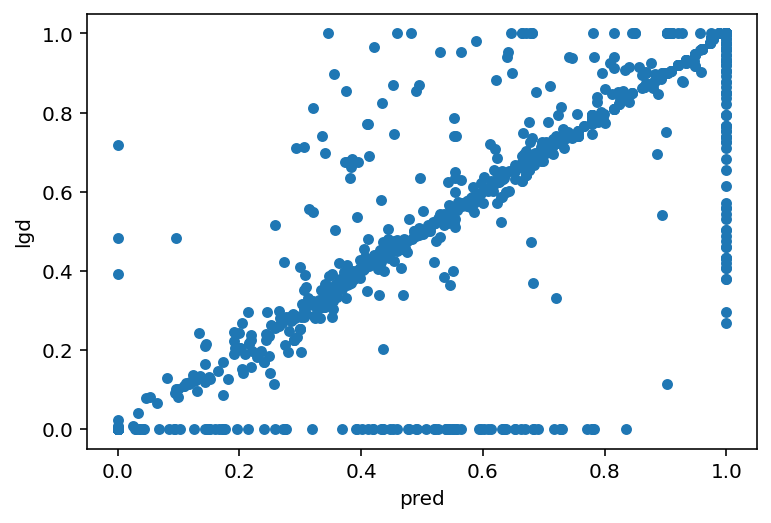

In [73]:
analysis = pd.concat([target, pd.Series(cb_pred_smoothed, name='pred', index=X_train.index)],axis=1)
analysis.plot(kind='scatter', x='pred', y='lgd');

Видно, что самые сертезные ошибки связаны с тем, что модель выдает 1, когда это не нужно и не выдает 0, когда это нужно.

Проанализируем важность признаков.

In [74]:
pool = Pool(X_train_cb, target, cat_features=categorical)

In [75]:
cb_reg.get_feature_importance(data=pool,
                       type='PredictionValuesChange',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

,Feature Id,Importances
0,bus_age,35.605492
1,col_cat,21.794060
2,fin_statement,14.249535
3,ar_revenue,14.233905
4,debt_equity,5.095083
5,debt_op_profit,4.650444
6,capital_cat,3.550796
7,safe_debtor,0.699030
8,rev_cat,0.121655


Самый важный признак - срок ведения бизнеса, это было видно на этапе анализа - он есть у всех объектов и сильная корреляция с таргетом.

Второй по важности - категория залога, третий и четвертый - выручка и наличие финансовой отчетности. Прочие сгенерированные признаки обладают не очень высокой важностью, но способствовали достижению MAE на кросс-валидации около 8.6%

Также важно сравить с константной моделью - медианным значением LGD по обучающей выборке.

In [76]:
mean_absolute_error(target, [np.median(target) for i in target])

0.3095013548903847

Наша модель значительно лучше.

# 4. Submit

Создадим функцию для формирования файла сабмита.

In [77]:
def output(model,test, name):
    
    predictions = model.predict(test)
    predictions = [1 if pred > 0.99 else 0 if pred < 0.02 else pred for pred in predictions]
    predictions = np.column_stack((test.index, predictions))
    predictions = pd.DataFrame(predictions, columns=['id', 'predict'])
    predictions['id'] = predictions['id'].astype('int')
    predictions = predictions.set_index('id')
    return predictions.to_csv(name+'.csv', index='id')

In [78]:
output(cb_reg, X_test, 'Final_CatBoost_default')